In [2]:
import torch
import numpy as np
import pandas as pd
from itertools import product
import matplotlib.pyplot as plt
import torch.nn.functional as F
from skimage import measure
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from mpl_toolkits.mplot3d import Axes3D
from collections import deque
import pyvista as pv
pv.start_xvfb()


import plotly.graph_objects as go
import plotly.express as px


%load_ext autoreload
%autoreload 2
from help_functions.make_conv_2d_torch import make_conv_2d_torch
from help_functions.make_conv_3d_torch import make_conv_3d_torch
from help_functions.morph_fill import morph_fill, morph_fill_fast
from help_functions.Sub_AT_torch import Sub_AT_torch
from help_functions.Sub_A_torch import Sub_A_torch
from help_functions.solve_least_squares_subdivision import solve_least_squares_subdivision
from help_functions.plot_subdivision_points import plot_subdivision_points
# from help_functions.solve_least_squares_subdivision import apply_C
from help_functions.shadows_visual import shadows_visual, shadows_visual_UI, shadows_visual_volume_plotly
from help_functions.fast_optimization import (Sub_A_fast, 
                                              Sub_AT_fast, 
                                              solve_least_squares_subdivision_fast,
                                              solve_least_squares_subdivision_CG)

from help_functions.make_html_visual import make_html_visual
from help_functions.make_scatter_visual import make_scatter_visual

from IPython.display import HTML
import kaleido
import plotly.io as pio



/tmp/ipykernel_1648/3554822085.py:12: PyVistaDeprecationWarning: This function is deprecated and will be removed in future version of PyVista. Use vtk with osmesa instead.
  pv.start_xvfb()


In [3]:
'''
Здесь импортируем изображение, центрируем и поворачиваем при надобности
'''

raw_data = np.loadtxt('./models/BuddaAll.txt').reshape(-1)
int_cast_data = np.trunc(raw_data*6000).astype(int).reshape(-1, 3)


shifted = (int_cast_data - int_cast_data.min(axis=0) + np.array([10,10,10]))
sizes = (int_cast_data.max(axis=0) - int_cast_data.min(axis=0) + np.array([20,20, 20])).astype(int)
budda_tensor_3D = torch.zeros(tuple(sizes), dtype=torch.float16)

budda_tensor_3D[shifted[:, 0], shifted[:, 1], shifted[:, 2]] = 1

budda_tensor_3D_rotated_90 = torch.rot90(input = budda_tensor_3D, k=1, dims=(1, 2))

print (f"Количество точек {len(torch.argwhere(budda_tensor_3D != 0))}")

# make_scatter_visual(budda_tensor_3D_rotated_90, 'budda_input_data')
# make_html_visual(tensor_3d=budda_tensor_3D, name='budda-raw', colorscale='Jet')

budda_tensor_3D = budda_tensor_3D_rotated_90


Количество точек 438282


In [4]:
budda_tensor_3D.dtype

torch.float16

In [14]:
'''
Здесь утолщаем границы
'''

# budda_tensor_3D_slice = budda_tensor_3D[:,:, 30]

# kernel_2D = torch.ones(size=(3,3))
kernel_shape = 9
kernel_3D = torch.ones(size=(kernel_shape,kernel_shape,kernel_shape))


# budda_conv_result_2D = make_conv_2d_torch(source=budda_tensor_3D_slice, kernel=kernel_2D)
budda_conv_result_3D = make_conv_3d_torch(source=budda_tensor_3D, kernel=kernel_3D)
# budda_conv_result_3D = budda_tensor_3D



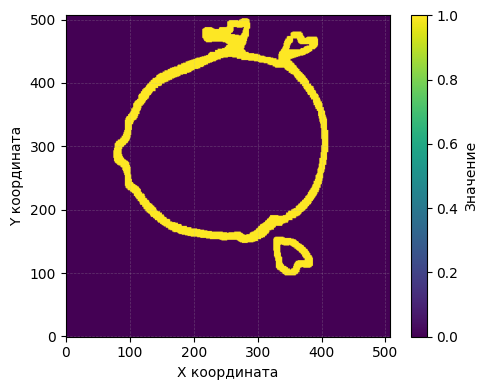

In [18]:
plt.figure(figsize=(5, 4))
    
plt.imshow(budda_conv_result_3D[:,:, 700], 
           cmap='viridis', 
           aspect='auto',
           origin='lower')  

plt.colorbar(label='Значение')
plt.xlabel('X координата')
plt.ylabel('Y координата')

plt.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.savefig('./images/budda-2d-slice-after-conv.png')
plt.show()


In [5]:
make_html_visual(budda_conv_result_3D, 'budda_conv_result_3D_3')
# HTML(filename='./htmls/voxel_model_budda_5_rare.html')

Файл сохранен в ./htmls/budda_conv_result_3D_3.html


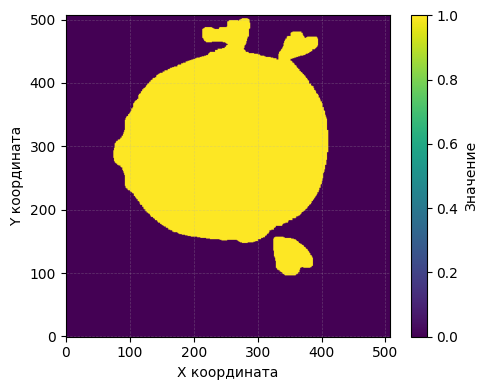

In [19]:
'''
Морфологическое заполнение
'''


# budda_conv_result_2D_filled = morph_fill(budda_conv_result_3D[:,:, 100])

budda_conv_result_2D_filled = morph_fill_fast(budda_conv_result_3D[:,:, 700])

plt.figure(figsize=(5, 4))
    
plt.imshow(budda_conv_result_2D_filled, 
           cmap='viridis', 
           aspect='auto',
           origin='lower')  

plt.colorbar(label='Значение')
plt.xlabel('X координата')
plt.ylabel('Y координата')

plt.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.savefig('./images/turbine_slice_conv_filled.png')
plt.show()

In [20]:
# budda_conv_result_3D_filled = morph_fill_fast(budda_conv_result_3D)

budda_conv_result_3D_filled = budda_conv_result_3D.clone()
for layer in range (budda_conv_result_3D.shape[2]):
    budda_conv_result_3D_filled[:,:,layer] = morph_fill_fast(budda_conv_result_3D_filled[:,:,layer])



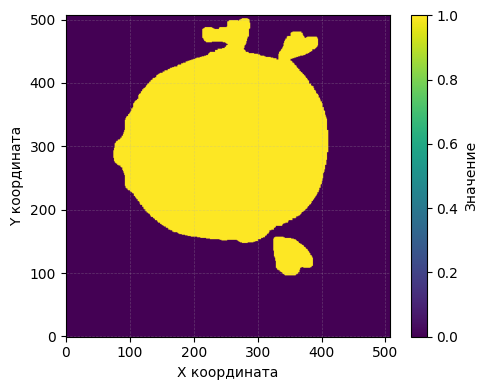

In [22]:
plt.figure(figsize=(5, 4))
    
plt.imshow(budda_conv_result_3D_filled[:, :, 700], 
           cmap='viridis', 
           aspect='auto',
           origin='lower')  

plt.colorbar(label='Значение')
plt.xlabel('X координата')
plt.ylabel('Y координата')

plt.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.savefig('./images/turbine_slice_conv_filled.png')
plt.show()

In [23]:
mask = torch.tensor([0, 1, 3, 3, 1], dtype=torch.float32) / 4

# Z - характористическая функция поверхности
Z = budda_conv_result_3D_filled


x0 = solve_least_squares_subdivision_CG(Z, mask, j = 3, tol = 1e-2, max_iter=1000)
# z_rec = Sub_A_torch(mask, x0)

# error = torch.norm(z_rec - Z)
# print(error)

CG ITER 0: residual = 1.633340e+04
CG ITER 1: residual = 7.711639e+03
CG ITER 2: residual = 4.482129e+03
CG ITER 3: residual = 2.742280e+03
CG ITER 4: residual = 1.863757e+03
CG ITER 5: residual = 1.430119e+03
CG ITER 6: residual = 1.132620e+03
CG ITER 7: residual = 9.160322e+02
CG ITER 8: residual = 7.110324e+02
CG ITER 9: residual = 5.659199e+02
CG ITER 10: residual = 4.708348e+02
CG ITER 11: residual = 3.918537e+02
CG ITER 12: residual = 3.267477e+02
CG ITER 13: residual = 2.822428e+02
CG ITER 14: residual = 2.481100e+02
CG ITER 15: residual = 2.206084e+02
CG ITER 16: residual = 1.924845e+02
CG ITER 17: residual = 1.689411e+02
CG ITER 18: residual = 1.485795e+02
CG ITER 19: residual = 1.323542e+02
CG ITER 20: residual = 1.161619e+02
CG ITER 21: residual = 1.039172e+02
CG ITER 22: residual = 9.362173e+01
CG ITER 23: residual = 8.375393e+01
CG ITER 24: residual = 7.609700e+01
CG ITER 25: residual = 6.751142e+01
CG ITER 26: residual = 5.946584e+01
CG ITER 27: residual = 5.364160e+01
CG

In [26]:
torch.save(x0, './tensor_files/x0_6000_9_j3.pt') 

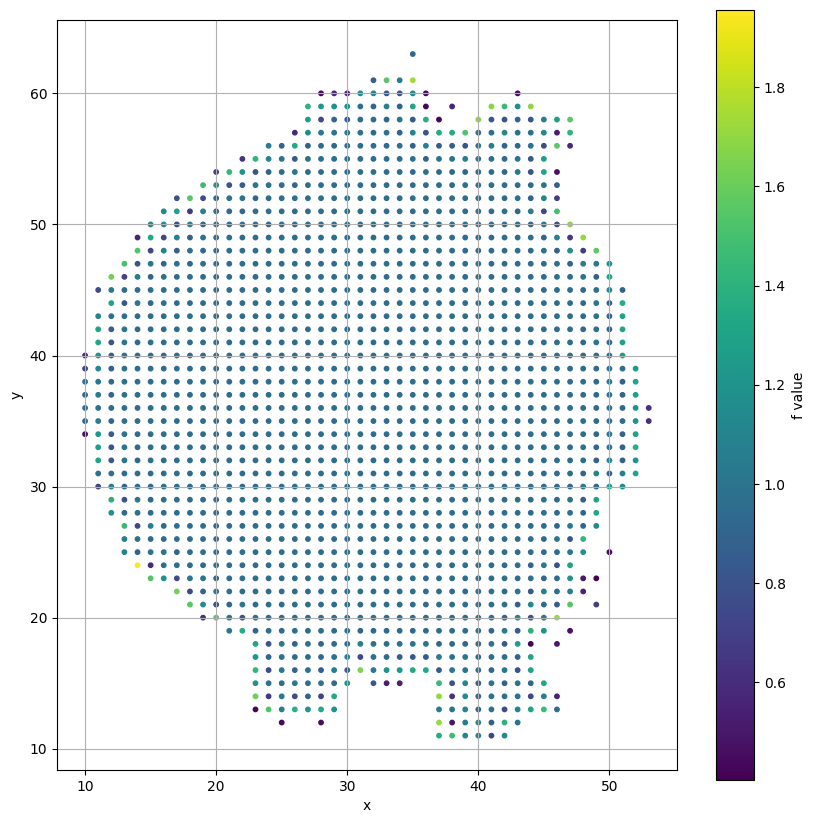

In [32]:
plot_subdivision_points(x0[:,:,78], threshold=0.4, do_ceil=False)

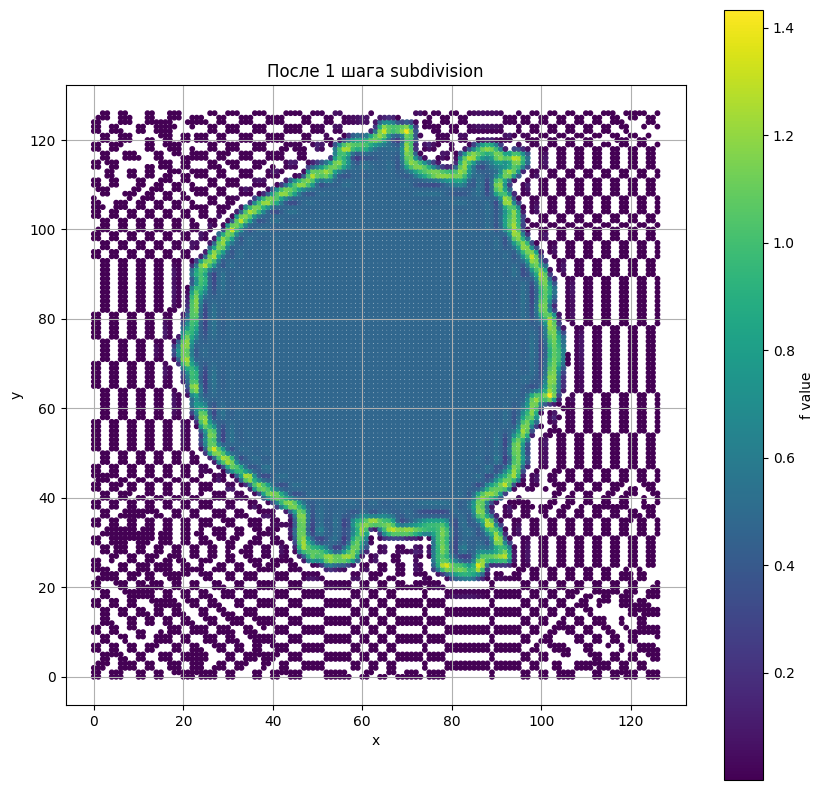

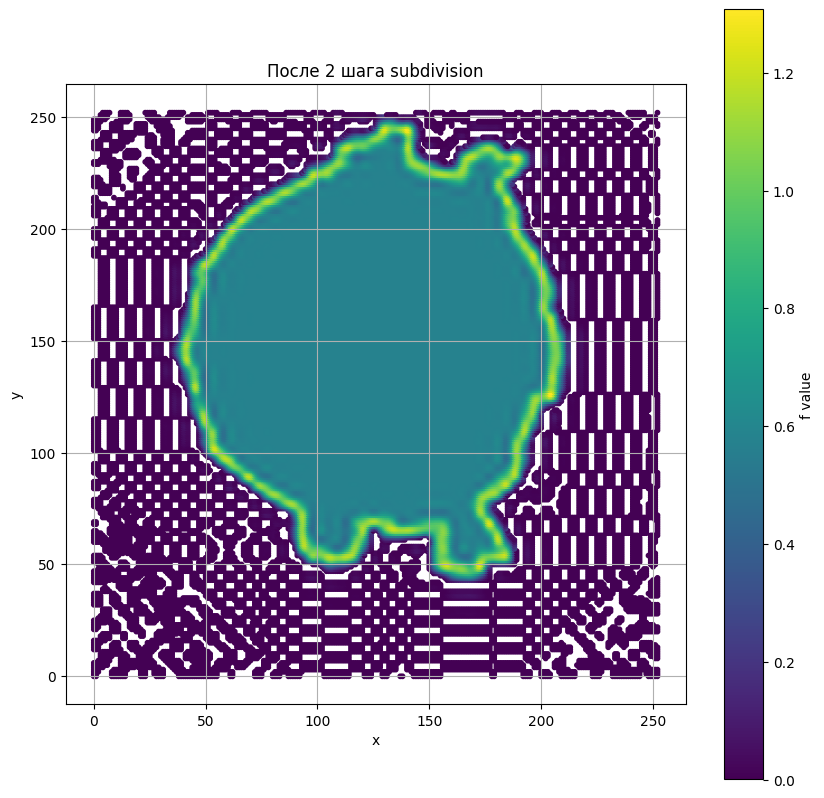

In [ ]:
x0_subdivisioned = x0.clone()
k = 2
for i in range(3):
    x0_subdivisioned = Sub_A_torch(mask, x0_subdivisioned)
    plot_subdivision_points(
        x0_subdivisioned[:,:,80*k],
        threshold=0.00,
        title=f"После {i+1} шага subdivision",
        figsize=(10,10),
        do_ceil= False,
        visual_type= 'scatter'
    )
    k *=2
    # print(k)

In [30]:
# x0_clone = Sub_A_torch(mask, x0_clone)

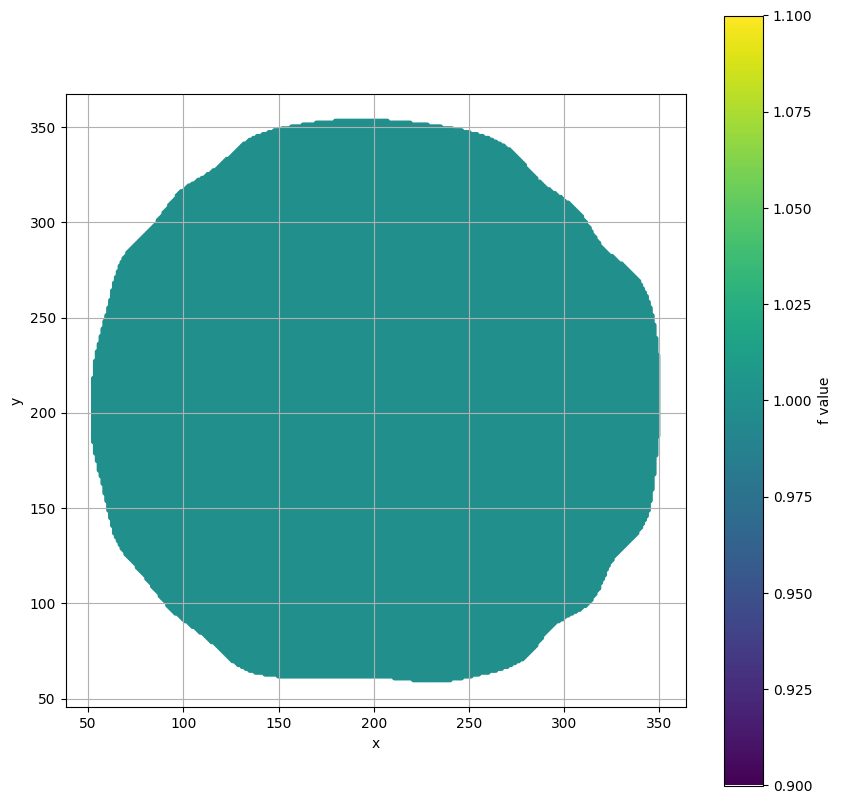

In [59]:
threshold = 0.4
# x0_clone_filtered = torch.where(x0_clone > threshold, x0_clone, torch.tensor(0.0))

x0_clone_filtered_ceil = (x0_subdivisioned > threshold).float()
plot_subdivision_points(data = x0_clone_filtered_ceil[:,:,10*16],
                        threshold=0.0,
                        title='',
                        figsize=(10,10),
                        do_ceil=False,
                        visual_type='scatter')

In [60]:
shadows_visual(x0_clone_filtered_ceil, name = 'budda_subdivisioned_1000_j3_sub5_vertical', layers = 'vertical')
# shadows_visual_UI(x0, name = 'budda_voxel_5000_vertical', layers = 'vertical')



In [ ]:
shadows_visual_volume_plotly(x0_clone_filtered_ceil, name = 'orange_budda_subdivisioned_5000_j3_sub3_vertical', layers = 'vertical')
shadows_visual_volume_plotly(Z, name = 'orange_budda_voxel_5000_vertical', layers = 'vertical')

In [32]:
Z.shape

torch.Size([426, 426, 1010])

In [33]:
x0_clone_filtered_ceil.shape

torch.Size([425, 425, 1009])

In [2]:
# import torch
# import numpy as np
# import plotly.graph_objects as go

# def visualize_tensor_isosurface(volume: torch.Tensor,
#                                 isomin=0.5,
#                                 isomax=1.0,
#                                 downsample=1):

#     # Переводим в numpy
#     vol = volume.detach().cpu().numpy()

#     D, H, W = vol.shape

#     # Создаём координатную сетку
#     z, y, x = np.mgrid[
#         0:D:downsample,
#         0:H:downsample,
#         0:W:downsample
#     ]

#     values = vol[::downsample, ::downsample, ::downsample]

#     fig = go.Figure(data=go.Isosurface(
#         x=x.flatten(),
#         y=y.flatten(),
#         z=z.flatten(),
#         value=values.flatten(),

#         isomin=isomin,
#         isomax=isomax,

#         surface_count=1,  # одна поверхность
#         colorscale="viridis",

#         caps=dict(x_show=False, y_show=False, z_show=False),

#         lighting=dict(
#             ambient=0.4,
#             diffuse=0.8,
#             specular=0.5,
#             roughness=0.3
#         )
#     ))

#     fig.update_layout(
#         scene=dict(
#             xaxis=dict(visible=False),
#             yaxis=dict(visible=False),
#             zaxis=dict(visible=False),
#             aspectmode="data"
#         ),
#         margin=dict(l=0, r=0, b=0, t=0)
#     )

#     fig.show()


In [5]:
# visualize_tensor_isosurface(x0_clone_filtered_ceil, isomin=0.5, downsample=2)